<a href="https://colab.research.google.com/github/ImaanA-1/DataQuest_Rec_System/blob/main/rec_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn import model_selection, preprocessing
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import sys
from collections import defaultdict

In [2]:
#Checking whether the device is gpu or cpu
#Program works better on gpu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
from google.colab import files
uploaded = files.upload()

Saving dq_recsys_challenge_2025(in).csv to dq_recsys_challenge_2025(in).csv


In [5]:
import io
df = pd.read_csv(io.StringIO(uploaded['dq_recsys_challenge_2025(in).csv'].decode('utf-8')))

In [6]:
df.head(10)

,idcol,interaction,int_date,item,page,tod,item_type,item_descrip,segment,beh_segment,active_ind
0,755,DISPLAY,17-Jan-23,NONE,Screen1,Afternoon,ALL,NaN,segment3,B01,Semi Active
1,4521,DISPLAY,27-Feb-23,NONE,Screen1,Afternoon,ALL,NaN,segment1,B07,Semi Active
2,4521,DISPLAY,18-Feb-23,NONE,Screen1,Afternoon,ALL,NaN,segment1,B07,Semi Active
3,4521,DISPLAY,30-Jan-23,NONE,Screen1,Morning,ALL,NaN,segment1,B07,Semi Active
4,4521,CLICK,5-Feb-23,IBAB,Screen1,Afternoon,INSURE,GENERIC MESSAGE,segment1,B07,Semi Active
5,4521,CHECKOUT,5-Feb-23,IBAB,Screen1,Afternoon,INSURE,GENERIC MESSAGE,segment1,B07,Semi Active
6,6145,DISPLAY,26-Feb-23,NONE,Screen1,Evening,ALL,NaN,segment3,B01,Cold Start
7,6145,DISPLAY,27-Jan-23,NONE,Screen1,Early,ALL,NaN,segment3,B01,Cold Start
8,6145,DISPLAY,10-Feb-23,NONE,Screen1,Morning,ALL,NaN,segment3,B01,Cold Start
9,6145,DISPLAY,10-Jan-23,NONE,Screen1,Afternoon,ALL,NaN,segment3,B01,Cold Start


In [7]:
#This class prepares the dataset for training and validation

class RecSysDataset(Dataset):

    def __init__(self, users, products, interactions):
        self.users = users
        self.products = products

        self.interaction_map = {'DISPLAY': 1.0, 'CLICK': 2.0, 'CHECKOUT': 3.0}
        self.interactions = np.array([self.interaction_map[i] for i in interactions])

    #Returns the total number of samples in the dataset
    def __len__(self):
        return len(self.users)

    #Retrieves a sample from the dataset at the specified index
    def __getitem__(self, item):
        users = self.users[item]
        products = self.products[item]
        interactions = self.interactions[item]

        return{
            "users": torch.tensor(users, dtype=torch.long),
            "products": torch.tensor(products, dtype=torch.long),
            "interactions": torch.tensor(interactions, dtype=torch.float),
        }

In [8]:
class RecommendationSystemModel(nn.Module):
    def __init__(
        self,
        num_users,
        num_products,
        embedding_size=256,
        hidden_dim=256,
        dropout_rate=0.2,
    ):
        super(RecommendationSystemModel, self).__init__()
        self.num_users = num_users
        self.num_products = num_products
        self.embedding_size = embedding_size
        self.hidden_dim = hidden_dim

        # Embedding layers
        self.user_embedding = nn.Embedding(
            num_embeddings=self.num_users, embedding_dim=self.embedding_size
        )
        self.product_embedding = nn.Embedding(
            num_embeddings=self.num_products, embedding_dim=self.embedding_size
        )

        # Hidden layers
        self.fc1 = nn.Linear(2 * self.embedding_size, self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim, 1)

        # Dropout layer
        self.dropout = nn.Dropout(p=dropout_rate)

        # Activation function
        self.relu = nn.ReLU()

    def forward(self, users, products):
        # Embeddings
        user_embedded = self.user_embedding(users)
        product_embedded = self.product_embedding(products)

        # Concatenate user and product embeddings
        combined = torch.cat([user_embedded, product_embedded], dim=1)

        # Pass through hidden layers with ReLU activation and dropout
        x = self.relu(self.fc1(combined))
        x = self.dropout(x)
        output = self.fc2(x)

        return output

In [9]:
#Preprocessing and encoding idcol and item into a format that the model can use

le_user = preprocessing.LabelEncoder()
le_item = preprocessing.LabelEncoder()
df.idcol = le_user.fit_transform(df.idcol.values)
df.item = le_item.fit_transform(df.item.values)


#Splitting the dataset into training and validation set

df_train, df_val = model_selection.train_test_split(
    df, test_size=0.1, random_state=3, stratify=df.interaction.values
)

train_dataset = RecSysDataset(
    users=df_train.idcol.values,
    products=df_train.item.values,
    interactions=df_train.interaction.values,
)

valid_dataset = RecSysDataset(
    users=df_val.idcol.values,
    products=df_val.item.values,
    interactions=df_val.interaction.values,
)

In [10]:
#Initializing data loaders
BATCH_SIZE = 2

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1
)
val_loader = DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1
)

In [11]:
#Setting up the training loop
recommendation_model = RecommendationSystemModel(
    num_users=len(le_user.classes_),
    num_products=len(le_item.classes_),
    embedding_size=64,
    hidden_dim=128,
    dropout_rate=0.1,
).to(device)

optimizer = torch.optim.Adam(recommendation_model.parameters(), lr=1e-3)
loss_func = nn.MSELoss()

In [12]:
EPOCHS = 2


# Function to log progress
def log_progress(epoch, step, total_loss, log_progress_step, data_size, losses):
    avg_loss = total_loss / log_progress_step
    sys.stderr.write(
        f"\r{epoch+1:02d}/{EPOCHS:02d} | Step: {step}/{data_size} | Avg Loss: {avg_loss:<6.9f}"
    )
    sys.stderr.flush()
    losses.append(avg_loss)

In [13]:
#Training loop

total_loss = 0
log_progress_step = 100
losses = []
train_dataset_size = len(train_dataset)
print(f"Training on {train_dataset_size} samples...")

recommendation_model.train()
for e in range(EPOCHS):
    step_count = 0  # Reset step count at the beginning of each epoch
    for i, train_data in enumerate(train_loader):
        output = recommendation_model(
            train_data["users"].to(device), train_data["products"].to(device)
        )
        # Reshape the model output to match the target's shape
        output = output.squeeze()  # Removes the singleton dimension
        interaction = (
            train_data["interactions"].to(torch.float32).to(device)
        )  # Assuming interactions is already 1D

        loss = loss_func(output, interaction)
        total_loss += loss.sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Increment step count by the actual size of the batch
        step_count += len(train_data["users"])

        # Check if it's time to log progress
        if (
            step_count % log_progress_step == 0 or i == len(train_loader) - 1
        ):  # Log at the end of each epoch
            log_progress(
                e, step_count, total_loss, log_progress_step, train_dataset_size, losses
            )
            total_loss = 0

Training on 360000 samples...


02/02 | Step: 360000/360000 | Avg Loss: 0.072409796

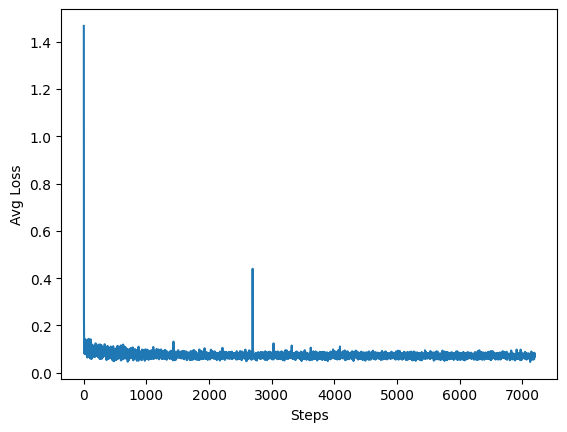

In [14]:
#Visualizing average losses over time
plt.figure()
plt.plot(losses)
plt.xlabel("Steps")
plt.ylabel("Avg Loss")
plt.show()

In [15]:
#Calculating the root mean square error
#Low RMSE =  higher accuracy
y_pred = []
y_true = []

recommendation_model.eval()

with torch.no_grad():
    for i, valid_data in enumerate(val_loader):
        output = recommendation_model(
            valid_data["users"].to(device), valid_data["products"].to(device)
        )
        interactions = valid_data["interactions"].to(device)
        y_pred.extend(output.cpu().numpy())
        y_true.extend(interactions.cpu().numpy())

# Calculate RMSE
rms = mean_squared_error(y_true, y_pred)
print(f"RMSE: {rms:.4f}")

RMSE: 0.1352


In [16]:
#Looking at the relevance (precision) and proportion of relevant products (recall) in the top-5 recommendations

def calculate_precision_recall(user_interactions, k, threshold):
    user_interactions.sort(key=lambda x: x[0], reverse=True)
    n_rel = sum(true_r >= threshold for _, true_r in user_interactions)
    n_rec_k = sum(est >= threshold for est, _ in user_interactions[:k])
    n_rel_and_rec_k = sum(
        (true_r >= threshold) and (est >= threshold) for est, true_r in user_interactions[:k]
    )

    precision = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
    recall = n_rel_and_rec_k / n_rel if n_rel != 0 else 1
    return precision, recall


user_interactions_comparison = defaultdict(list)

with torch.no_grad():
    for valid_data in val_loader:
        users = valid_data["users"].to(device)
        products = valid_data["products"].to(device)
        interactions = valid_data["interactions"].to(device)
        output = recommendation_model(users, products)

        for user, pred, true in zip(users, output, interactions):
            user_interactions_comparison[user.item()].append((pred[0].item(), true.item()))

user_precisions = dict()
user_based_recalls = dict()

k = 50
threshold = 3

for idcol, user_interactions in user_interactions_comparison.items():
    precision, recall = calculate_precision_recall(user_interactions, k, threshold)
    user_precisions[idcol] = precision
    user_based_recalls[idcol] = recall

In [17]:
average_precision = sum(prec for prec in user_precisions.values()) / len(
    user_precisions
)
average_recall = sum(rec for rec in user_based_recalls.values()) / len(
    user_based_recalls
)

print(f"precision @ {k}: {average_precision:.4f}")
print(f"recall @ {k}: {average_recall:.4f}")

precision @ 50: 1.0000
recall @ 50: 0.7259


In [22]:
#Predicts the top 5 products that a user hasn't bought but might buy

def recommend_top_products(model, idcol, all_products, purch_prod, device, k=5, batch_size=100):
    model.eval()
    not_purch = [p for p in all_products if p not in purch_prod]
    predictions = []

    if len(purch_prod) == 0:
      top_by_type = df.groupby('item_type')['item'].count().sort_values(ascending=False).head(k)
      return top_by_type.index.tolist()

    with torch.no_grad():
        for i in range(0, len(not_purch), batch_size):
            batch_not_purch = not_purch[i:i+batch_size]
            user_tensor = torch.tensor([idcol] * len(batch_not_purch)).to(device)
            product_tensor = torch.tensor(batch_not_purch).to(device)
            predicted_ratings = model(user_tensor, product_tensor).view(-1).tolist()
            predictions.extend(zip(batch_not_purch, predicted_ratings))

    predictions.sort(key=lambda x: x[1], reverse=True)
    top_k_products = [item for item, _ in predictions[:k]]
    return top_k_products

def get_products_with_type(item, df):
    # Select the relevant products and create a new DataFrame
    products_with_type = df[df['item'].isin(item)][['item', 'item_type']].copy()
    # Drop duplicates before concatenation
    products_with_type = products_with_type.drop_duplicates()
    # Concatenate products with their type
    products_with_type['item_with_type'] = products_with_type.apply(
        lambda x: f"{x['item']} - {x['item_type']}", axis=1
    )
    return products_with_type['item_with_type'].tolist()


# Get user input for idcol
while True:
    try:
        idcol = int(input("Enter the user ID you want recommendations for: "))
        # Validate that the user exists in the dataset
        if idcol not in df['idcol'].unique():
            print(f"User ID {idcol} not found in the dataset. Please try again.")
            continue
        break
    except ValueError:
        print("Please enter a valid integer user ID.")

# Prepare all_products and seen_products
all_products = df['item'].unique().tolist()
purch_prod = set(df[df['idcol'] == idcol]['item'].tolist())

# Get recommendations
recommendations = recommend_top_products(
    recommendation_model, idcol, all_products, purch_prod, device
)

# Get products with types for recommended and purchased products
recommended_products_with_types = get_products_with_type(recommendations, df)

# For the user's top 10 rated purchased products, get products with types
user_top_ten_purch_prod = df[df['idcol'] == idcol].sort_values(by="interaction", ascending=False).drop_duplicates(subset=['item']).head(10)
purch_prod_with_type = get_products_with_type(user_top_ten_purch_prod['item'], df)

# Print with vertical rankings
print("Recommended products:\n")
for i, rec in enumerate(recommended_products_with_types, 1):
    print(f"{i}. {rec}")

print("\nBased on these products the user has bought/viewed:\n")
for i, prod in enumerate(purch_prod_with_type, 1):
    print(f"{i}. {prod}")

Enter the user ID you want recommendations for: 755
Recommended products:

1. 35 - INVEST
2. 8 - LEND
3. 7 - LEND
4. 36 - INVEST
5. 86 - INVEST

Based on these products the user has bought/viewed:

1. 23 - CONNECT
